In [286]:
from matplotlib import rcParamsDefault
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

class CSVTrafficDataloader:
    def __init__(self, file_path, K):
        self.file_path = file_path
        self.K = K
        self.data = None
        self.train_data = None
        self.test_data = None
    
    def load_data(self):
        try:
            self.data = pd.read_csv(self.file_path)[["Year", "Month", "Flt"]]

        except Exception as e:
            print(f"Error loading data from file {self.file_path}: {e}")
            return None

    def preprocess_data(self, normalization=False):
        if self.data is not None:
            self.data["Flt"] = self._turn_col_to_int(self.data["Flt"])
        else:
            print("Data is not loaded. Call load_data first")

        if normalization:
            self.data["Flt"] = (self.data["Flt"] - self.data["Flt"].mean()) / self.data["Flt"].std()
    
    def create_lag_features(self, target_column='Flt'):
        """
        Create lag features for the time series data.
        
        :param K: The number of lag features to create.
        :param target_column: The name of the column for which to create lag features.
        """
        for i in range(1, self.K + 1):
            self.data[f'lag_{i}'] = self.data[target_column].shift(i)
        self.data.dropna(inplace=True)  # Dropping rows with NaN values resulting from the shift operation

    def _turn_col_to_int(self, arr):
        return arr.str.replace(",","").astype(int)
    
    def split_train_test(self, train_start_year=2003, train_end_year=2019):
    
        self.set_month_year_index()
        self.create_lag_features()

        if self.data is not None:
            # Splitting the data
            self.train_data = self.data[(self.data['Year'] >= train_start_year) & (self.data['Year'] <= train_end_year)].drop(["Year", "Month"], axis=1)
            self.test_data = self.data[(self.data['Year'] > train_end_year)].drop(["Year", "Month"], axis=1)
        else:
            print("Data not loaded. Call load_data and preprocess_data first")
            return None, None

    def split_train_validataion_test(self, train_start_year=2003, validation_start_year=2020, test_start_year = 2022):
    
        self.set_month_year_index()
        self.create_lag_features()

        if self.data is not None:
            # Splitting the data
            self.train_data = self.data[(self.data['Year'] >= train_start_year) & (self.data['Year'] < validation_start_year)].drop(["Year", "Month"], axis=1)
            self.validation_data = self.data[(self.data['Year'] >= validation_start_year) & (self.data['Year'] < test_start_year)].drop(["Year", "Month"], axis=1)
            self.test_data = self.data[(self.data['Year'] >= test_start_year)].drop(["Year", "Month"], axis=1)

        else:
            print("Data not loaded. Call load_data and preprocess_data first")
            return None, None
        
    def set_month_year_index(self):
        """
        Sets the DataFrame index as a combination of month and year.
        """
        # Assuming 'Month' and 'Year' are columns in the DataFrame
        self.data['Month_Year'] = pd.to_datetime(self.data[['Year', 'Month']].assign(DAY=1))
        self.data.set_index('Month_Year', inplace=True)

class LinearPredictor:
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        """
        Fit the linear model using the normal equation.
        :param X: Features (numpy array of shape [n_samples, n_features])
        :param y: Target values (numpy array of shape [n_samples])
        """
        # Adding a column of ones for the intercept
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        # Calculating weights using the Normal Equation
        self.weights = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    def predict(self, X):
        """
        Predict using the linear model.
        :param X: Samples (numpy array of shape [n_samples, n_features])
        :return: Returns predicted values.
        """
        if self.weights is None:
            raise Exception("Model is not fitted yet. Please call 'fit' with training data.")
        
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # add intercept term
        return pd.Series(X_b.dot(self.weights), index=X.index)
    
    def get_weights(self):
        """
        Get the learned weights of the model.
        :return: Returns the weights (numpy array)
        """
        return self.weights


class PerformanceEvaluator:
    def __init__(self, y_pred, y):
        if not isinstance(y, pd.Series) or not isinstance(y_pred, pd.Series):
            raise ValueError("y and y_pred must be pandas Series with a DateTimeIndex.")
        self.y_pred = y_pred
        self.y = y
        self.y_pred_df = pd.DataFrame({
            "Actual": self.y,
            "Predictions": self.y_pred
        })

    def _filter_by_time_window(self, start_year="2020", end_year="2023"):
        start_date = pd.to_datetime(f"{start_year}-01-01")
        end_date = pd.to_datetime(f"{end_year}-12-31")
        return self.y_pred_df.loc[start_date:end_date]

    def calculate_rmse(self, start_year="2020", end_year="2023"):
        filtered_df = self._filter_by_time_window(start_year, end_year)
        error = filtered_df['Predictions'] - filtered_df['Actual']
        mse = np.mean(error**2)
        rmse = np.sqrt(mse)
        return rmse

    def calculate_mape(self, start_year="2020", end_year="2023"):
        filtered_df = self._filter_by_time_window(start_year, end_year)
        error = filtered_df['Predictions'] - filtered_df['Actual']
        pct_error = np.abs(error / filtered_df['Actual']) * 100
        mape = np.mean(pct_error)
        return mape

    def plot_test_samples_with_predictions(self, start_year="2020", end_year="2023"):
        filtered_df = self._filter_by_time_window(start_year, end_year)
        
        plt.figure(figsize=(10, 6))
        plt.plot(filtered_df['Actual'], label='Actual', marker='o')
        plt.plot(filtered_df['Predictions'], label='Predictions', linestyle='--', marker='x')
        plt.title('Actual vs Predicted Values')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True) 
        plt.show()

        

def run_model(K, validation=False):

    loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv", K=K)
    loader.load_data()
    loader.preprocess_data()
    if validation:
        loader.split_train_validataion_test()
        X_train = loader.train_data.drop(["Flt"], axis=1)
        y_train = loader.train_data["Flt"]
        X_validation = loader.validation_data.drop(["Flt"], axis=1)
        y_validation = loader.validation_data["Flt"]
        X_test = loader.test_data.drop(["Flt"], axis=1)
        y_test = loader.test_data["Flt"]
        linear_regressor = LinearRegression()
        linear_regressor.fit(X_train, y_train)
        y_predict_validation = linear_regressor.predict(X_validation)
        y_predict_validation = pd.Series(y_predict_validation, index=y_validation.index)
        y_predict_test = linear_regressor.predict(X_test)
        y_predict_test = pd.Series(y_predict_test, index=y_test.index)
        evaluator_validation = PerformanceEvaluator(y_predict_validation, y_validation)
        evaluator_test = PerformanceEvaluator(y_predict_test, y_test)
        return evaluator_validation, evaluator_test
    else:
        loader.split_train_test()  
        X_train = loader.train_data.drop(["Flt"], axis=1)
        y_train = loader.train_data["Flt"]
        X_test = loader.test_data.drop(["Flt"], axis=1)
        y_test = loader.test_data["Flt"]
        linear_regressor = LinearRegression()
        linear_regressor.fit(X_train, y_train)
        y_predict = linear_regressor.predict(X_test)
        y_predict = pd.Series(y_predict, index=y_test.index)
        evaluator = PerformanceEvaluator(y_predict, y_test)

        return evaluator

def evaluate_for_K(initial_val, final_val, validation=False):
    results = []
    results_validation = []
    results_test = []

    if validation:
        for K in range(initial_val, final_val+1):
            evaluator_validation, evaluator_test = run_model(K, validation)
            rmse_validation = evaluator_validation.calculate_rmse()
            aux = {"K":K,
            "result":rmse_validation}
            results_validation.append(aux)
    
            rmse_test = evaluator_test.calculate_rmse()
            aux = {"K":K,
            "result":rmse_test}
            results_test.append(aux)
        
        return results_validation, results_test
    else:
        for K in range(initial_val, final_val+1):
            evaluator = run_model(K, validation)
            rmse = evaluator.calculate_rmse()
            aux = {"K":K,
            "result":rmse}
            results.append(aux)
        
        return results
    
def plot_learning_curves(model, X_train, y_train, X_test, y_test):
    train_errors, test_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

#### Item A

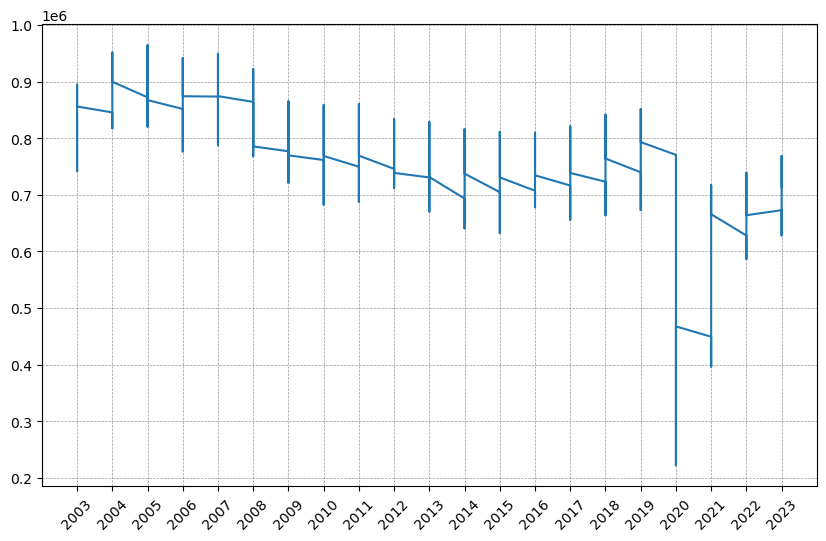

In [287]:
from sympy import rotations

loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv", K=1)
loader.load_data()
loader.preprocess_data()
data = loader.data

plt.figure(figsize=(10, 6))  
plt.xticks(range(data['Year'].min(), data['Year'].max() + 1), rotation=45)
plt.plot(data['Year'], data['Flt'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.8)


#### Item B1

least rmse: 92690.05162332
K: 4


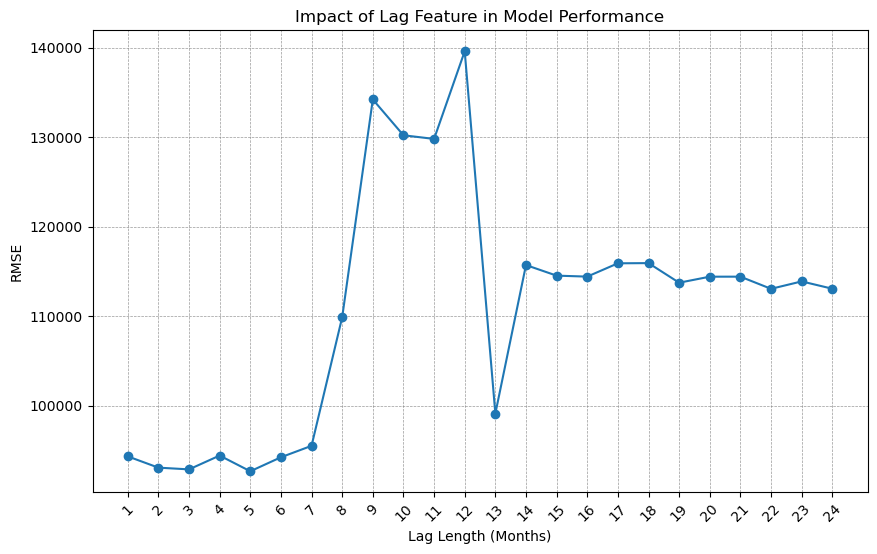

In [288]:
results = evaluate_for_K(1, 24)
results_df = pd.DataFrame(results)

plt.figure(figsize=(10,6))
plt.xticks(results_df["K"].to_numpy(), rotation=45)
plt.plot(results_df["K"], results_df["result"], marker="o")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.8)
plt.xlabel("Lag Length (Months)")
plt.ylabel("RMSE")
plt.title("Impact of Lag Feature in Model Performance")

print(f"least rmse: {results_df.loc[results_df['result'].idxmin(), 'result']}\nK: {results_df['result'].idxmin()}")

#### Item B2

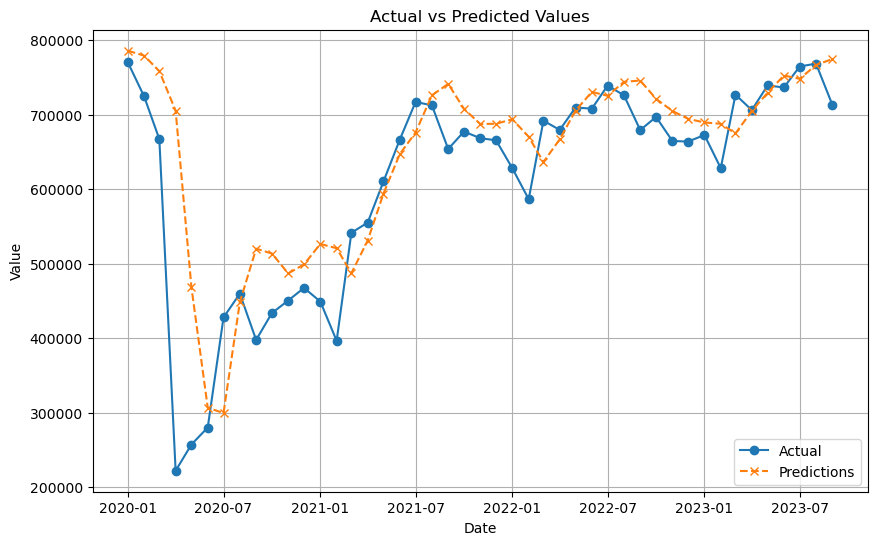

RMSE: 94444.91865993186
MAPE: 13.9798768012629


In [289]:
evaluator = run_model(K=4)
evaluator.plot_test_samples_with_predictions()
rmse = evaluator.calculate_rmse()
mape = evaluator.calculate_mape()
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

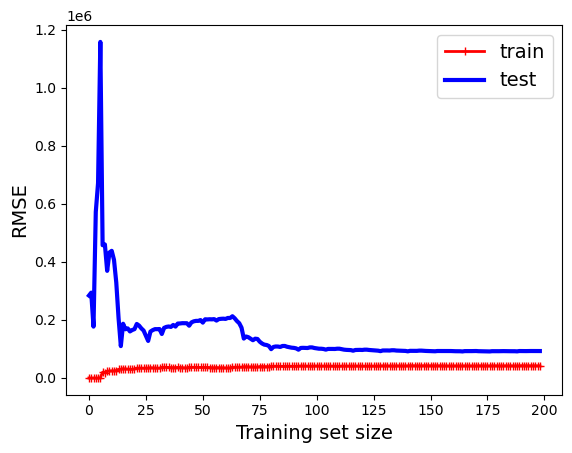

In [290]:
from sklearn.linear_model import LinearRegression

loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv", K=5)
loader.load_data()
loader.preprocess_data()
loader.split_train_test()  
X_train = loader.train_data.drop(["Flt"], axis=1)
y_train = loader.train_data["Flt"]
X_test = loader.test_data.drop(["Flt"], axis=1)
y_test = loader.test_data["Flt"]
linear_regressor = LinearRegression()
plot_learning_curves(linear_regressor, X_train, y_train, X_test, y_test)

#### Item B3

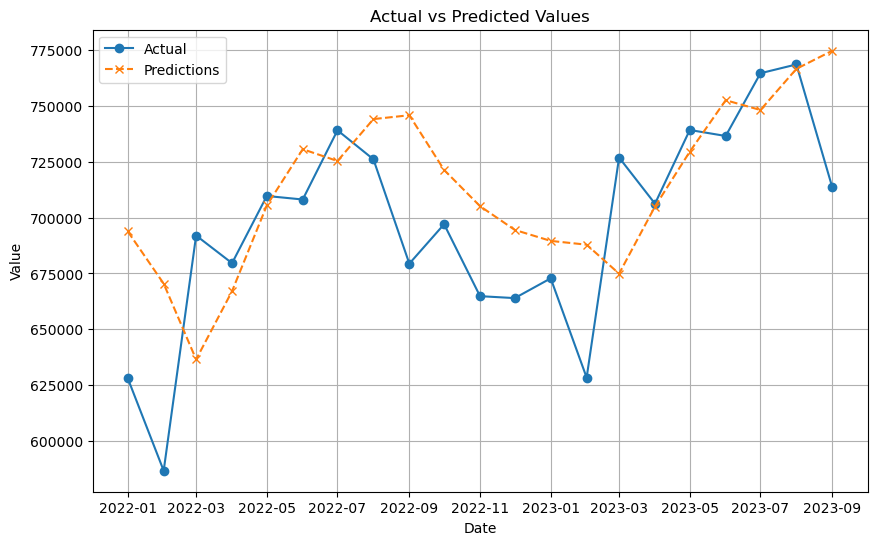

RMSE: 40298.94816967505
MAPE: 4.7843484070726925


In [291]:
evaluator.plot_test_samples_with_predictions(start_year=2022, end_year=2023)
rmse = evaluator.calculate_rmse(start_year=2022, end_year=2023)
mape = evaluator.calculate_mape(start_year=2022, end_year=2023)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

#### Item C

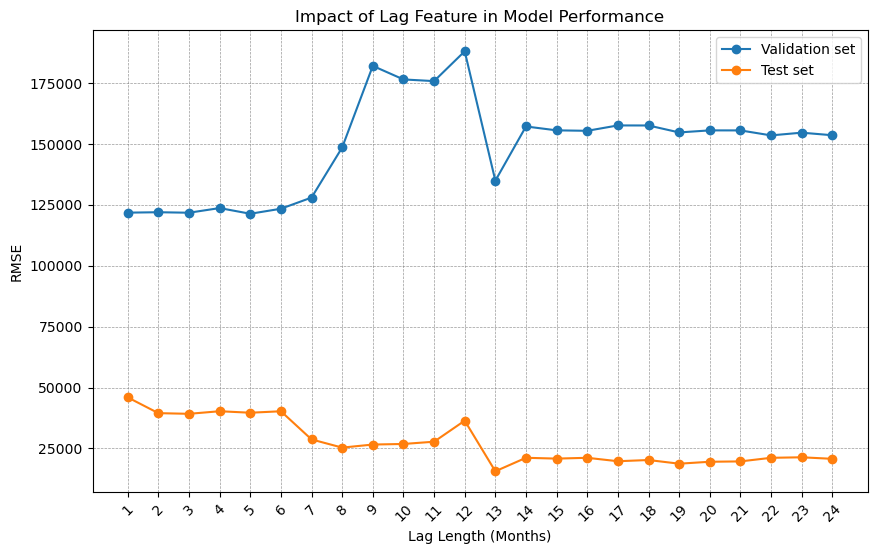

In [293]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the rest of your code is correct
results_validation, results_test = evaluate_for_K(1, 24, validation=True)

results_df_validation = pd.DataFrame(results_validation)
results_df_test = pd.DataFrame(results_test)

plt.figure(figsize=(10,6))

# Plotting the lines
plt.plot(results_df_validation["K"], results_df_validation["result"], marker="o", label="Validation set")
plt.plot(results_df_test["K"], results_df_test["result"], marker="o", label="Test set")

# Setting the x-axis ticks and labels
plt.xticks(results_df_validation["K"], rotation=45)

# Adding gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.8)

# Adding labels and title
plt.xlabel("Lag Length (Months)")
plt.ylabel("RMSE")
plt.title("Impact of Lag Feature in Model Performance")

# Adding legend
plt.legend()

# Show plot
plt.show()
